In [122]:
from astropy.nddata import CCDData
import matplotlib.pyplot as plt
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import scipy
from skimage.restoration import richardson_lucy
from astropy.convolution import Gaussian2DKernel

# ASTR 310 Lecture 21 - Images 2

### 1. Convolution

Read in the Large Magellanic Cloud FITS image file from lecture 18 and perform the following operations on it.  

**a.)** Display the original image with a nice color stretch, so that you can see structures within the galaxy, and with actual RA and Dec coordinates on the axes.  I found that a log stretch with vmin=-0.3 and vmax=1.0 worked well but you can experiment.  You may be able to do better.

[2 pts]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Changed DATE-OBS from '21/11/1998' to '1998-11-21''. [astropy.wcs.wcs]
/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_80100/1789750793.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img), vmin=-0.3, vmax=1, origin='lower')


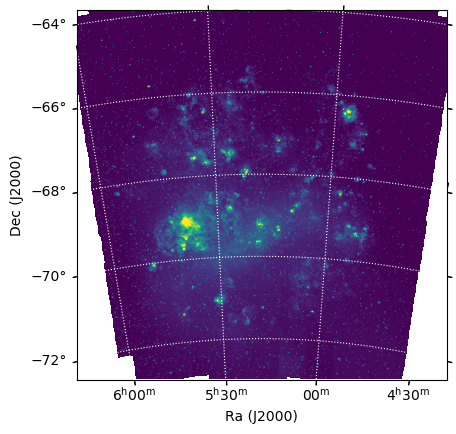

In [6]:
img = CCDData.read("../Lec18/lmc.ha.b20.fits", unit='1/s')

plt.subplot(projection=img.wcs)
plt.imshow(np.log10(img), vmin=-0.3, vmax=1, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

**b.)** Obtain the sizes of the pixels from the header information in the file.  Note that the XPIXSIZE and YPIXSIZE keywords in the header are incorrect because the original image pixels were binned to reduce the file size.  Instead, if you read the file with CCDdata.read, you can get the pixel sizes in degrees from img.wcs.wcs.cd[0][0] and img.wcs.wcs.cd[1][1].

[2 pts]

In [98]:
xpixsize = img.wcs.wcs.cd[0][0] * u.degree
ypixsize = img.wcs.wcs.cd[1][1] * u.degree

In [107]:
scale = 1*u.pixel/ypixsize
scale

<Quantity 60.00000089 pix / deg>

**c.)** Apply a Gaussian filter (smoothing) of width $\sigma = 1^\circ$  to the original image and plot the smoothed version.  Note that many smoothing algorithms require you to supply the kernel width in pixels.

[3 pts]

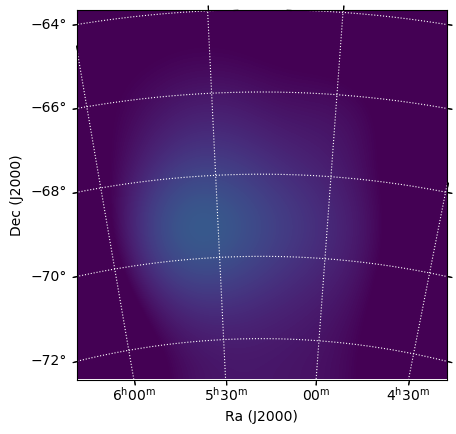

In [106]:
img2 = scipy.ndimage.gaussian_filter(img, scale.value)

plt.subplot(projection=img.wcs)
plt.imshow(np.log10(img2), vmin=-0.3, vmax=1, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

**d.)** Convolve the original image with a boxcar filter of width 1 degree and plot that.

[3 pts]

/var/folders/41/_gkgvhb94wd4156zplzr4cg00000gn/T/ipykernel_80100/3454137091.py:6: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(img3), vmin=-0.3, vmax=1, origin='lower')


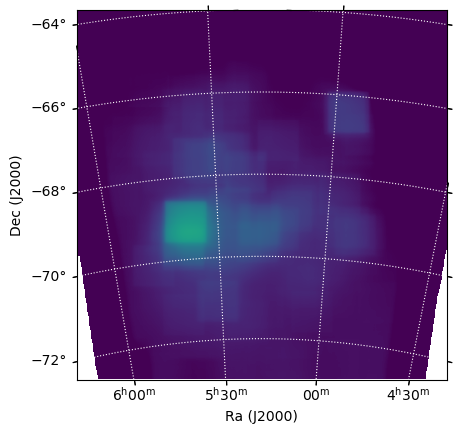

In [109]:
filter_size = int(scale.value)
boxcar_kernel = np.ones((filter_size, filter_size)) / (filter_size ** 2)
img3 = scipy.ndimage.convolve(img, boxcar_kernel)

plt.subplot(projection=img.wcs)
plt.imshow(np.log10(img3), vmin=-0.3, vmax=1, origin='lower')
plt.grid(color='white', ls='dotted')
plt.xlabel("Ra (J2000)")
plt.ylabel("Dec (J2000)")

### 2. Deconvolution

Continue working with that image of the LMC.

* Make a small cutout of the image; I suggest maybe 2.5 by 2 degrees centered on RA = $05^h14^m04^s$, Dec = $-69^\circ 15^\prime 0^{\prime\prime}$. 
* Smooth your image with a Gaussian of width $\sigma = 3^\prime$ to mimic the effect of atmospheric seeing or other limits on the resolution of the image.
* Implement the Richardson-Lucy algorithm on the smoothed image, and try to sharpen it up.  You should use your smoothing Gaussian kernel as the PSF; try something like 500 to 1000 iterations.   If you're using the canned richardson_lucy algorithm, and your results look strange, you might check the clip parameter.

* Display all three of the images (original, smoothed, and deconvolved) next to each other in a figure with subpanels for easy comparison.  Use the same stretch for all three panels.

You should be able to see that the deconvolution algorithm introduced ringing around the edges and around the bright sources.  Thus, there's no free lunch; remember that ordinarily we receive the smoothed version from the telescope, and we may try to recover a sharpened version, but deconvolution introduces artifacts.  The art of deconvolution is always to know when to stop and how much you can believe.

[10 pts]

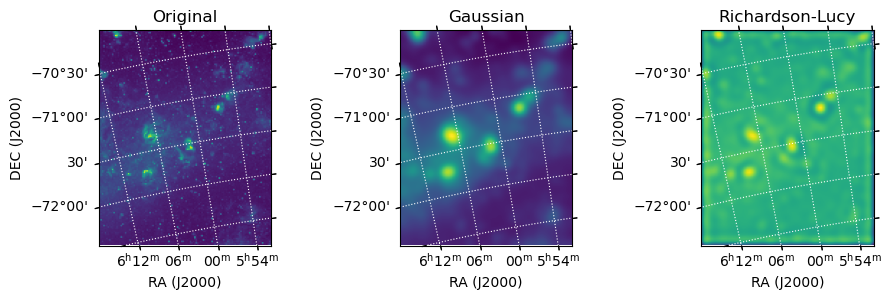

In [136]:
center = SkyCoord('05h14m04s -69d15m0s')
size = np.array([2.5, 2]) * u.degree

cut = Cutout2D(img.data, center, size, wcs=img.wcs)

fig2 = plt.figure(figsize=(10,10))
ax1 = fig2.add_subplot(131, projection=img.wcs)
ax2 = fig2.add_subplot(132, projection=img.wcs)
ax3 = fig2.add_subplot(133, projection=img.wcs)

cut2 = scipy.ndimage.gaussian_filter(cut.data, scale.value / 20)

gauss_kernal = Gaussian2DKernel(scale.value / 20)
psf = np.array(gauss_kernal)
cut3 = richardson_lucy(cut.data, psf, num_iter=10, clip=False)

ax1.imshow(np.log10(cut.data), origin='lower')
ax1.grid(color='white', ls='dotted')
ax1.set_ylabel("DEC (J2000)")
ax1.set_xlabel("RA (J2000)")
ax1.set_title("Original")

ax2.imshow(np.log10(cut2), origin='lower')
ax2.grid(color='white', ls='dotted')
ax2.set_ylabel("DEC (J2000)")
ax2.set_xlabel("RA (J2000)")
ax2.set_title("Gaussian")

ax3.imshow(np.log10(cut3), origin='lower')
ax3.grid(color='white', ls='dotted')
ax3.set_ylabel("DEC (J2000)")
ax3.set_xlabel("RA (J2000)")
ax3.set_title("Richardson-Lucy")

plt.subplots_adjust(wspace=0.75, hspace=0.4)

